<div align="center">

###### HW2

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Homework 2
</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Q1.
Select 2 hyper-parameters of the artificial neural network used in Lab 2, and set 3 different values for each. Perform experiments to compare the effects of varying these hyper-parameters on the loss and accuracy metrics across the training, validation, and test datasets. Present your findings with appropriate tables.

In [2]:
ROOT = '/content/drive/MyDrive/NTHU/Deep_Learning_HomeWork/HW1'
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100
VALIDATION_RATIO = 0.7
DEVICE = 'cpu' # 'cuda'
SEED = 42

In [3]:
# fix random seed
import numpy as np
import torch


torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


np.random.seed(SEED)

In [4]:
import os
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset


def _create_data_loader(data: np.ndarray, is_shuffle=True, is_drop_last=False):
    x_data = torch.from_numpy(data[:, :13]).float()
    y_data = torch.from_numpy(data[:, 13]).long()

    dataset = TensorDataset(x_data, y_data)
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=is_shuffle)

    return data_loader


def prepare_data_loaders():
    r"""
    Load raw training/testing data and create Pytorch data loaders.

    """

    # Training & Validation
    df = pd.read_csv(os.path.join(ROOT, 'heart_dataset_train_all.csv'))
    df = df.dropna()

    sex_description = {
        'Male': 0,
        'Female': 1,
    }

    df.loc[:, 'sex'] = df['sex'].map(sex_description)

    pain_description = {
        'low': 0,
        'medium': 1,
        'high': 2,
        'severe': 3
    }

    df.loc[:, 'cp'] = df['cp'].map(pain_description)


    np_data = df.values
    np.random.shuffle(np_data)
    split_point = int(len(df) * VALIDATION_RATIO)

    train_loader = _create_data_loader(np_data[:split_point, :], is_shuffle=True)
    val_loader = _create_data_loader(np_data[split_point:, :], is_shuffle=False)

    # Testing
    df = pd.read_csv(os.path.join(ROOT, 'heart_dataset_test.csv'))
    test_loader = _create_data_loader(df.values, is_shuffle=False)

    return train_loader, val_loader, test_loader


In [5]:
# Check your GPU status.
!nvidia-smi

Thu Mar 21 12:44:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# functions
import torch
import torch.nn as nn
import typing as ty

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR


@torch.no_grad
def evaluate(model, criterion, loader):
    model.eval()

    total_loss = 0
    correct = 0
    total_samples = 0

    for features, labels in loader:
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(features)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        predicted = outputs.argmax(-1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total_samples

    return avg_loss, accuracy


def train_one_epoch(model, criterion, optimizer, lr_scheduler, loader):
    model.train()

    total_loss = 0
    correct = 0
    total_samples = 0

    for features, labels in loader:
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(features)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = outputs.argmax(-1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    lr_scheduler.step()
    avg_loss = total_loss / len(loader)
    accuracy = correct / total_samples

    return avg_loss, accuracy


def run_training_process(model, num_epochs, train_loader, val_loader, test_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_val_acc = -1

    for epoch in range(num_epochs):
        avg_train_loss, train_accuracy = train_one_epoch(
            model, criterion, optimizer, lr_scheduler, train_loader
        )

        avg_val_loss, val_accuracy = evaluate(model, criterion, val_loader)

        # Store performance
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'model_classification.pth')


    # Evaluate testing performance using best validation weights
    model.load_state_dict(torch.load('model_classification.pth'))
    avg_test_loss, test_accuracy = evaluate(model, criterion, test_loader)

    return train_losses, train_accuracies, val_losses, val_accuracies, avg_test_loss, test_accuracy


def create_model(num_layers, hidden_dim):
  model = nn.Sequential()

  for i in range(num_layers):
    model.add_module(f'Linear {i+1}', nn.Linear(13 if i == 0 else hidden_dim, hidden_dim))
    model.add_module(f'ReLU {i+1}', nn.ReLU())

  model.add_module('Final Linear', nn.Linear(hidden_dim, 2))
  model.to(DEVICE)

  return model





In [7]:
r""" Main Process """

# Define a list of hyper-parameter configurations to experiment with
hyper_params = [

  {'num_layers': 1, 'hidden_dim': 2},
  {'num_layers': 2, 'hidden_dim': 2},
  {'num_layers': 3, 'hidden_dim': 2},
  {'num_layers': 1, 'hidden_dim': 256},
  {'num_layers': 2, 'hidden_dim': 256},
  {'num_layers': 3, 'hidden_dim': 256},
  {'num_layers': 1, 'hidden_dim': 1024},
  {'num_layers': 2, 'hidden_dim': 1024},
  {'num_layers': 3, 'hidden_dim': 1024},

]

# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders()

# Perform experiments for each hyper-parameter configuration
results = []

for config in hyper_params:
  # Create a new model with the specified hyper-parameters
  model = create_model(config['num_layers'], config['hidden_dim'])

  # Run training process
  train_losses, train_accuracies, val_losses, val_accuracies, test_loss, test_accuracy = \
    run_training_process(model, NUM_EPOCHS, train_loader, val_loader, test_loader)

  # Store the results for this configuration
  results.append({
    'num_layers': config['num_layers'],
    'hidden_dim': config['hidden_dim'],
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_loss': test_loss,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_accuracy': test_accuracy,
  })



<ipython-input-4-cd265c8f89b5>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'sex'] = df['sex'].map(sex_description)
<ipython-input-4-cd265c8f89b5>:40: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'cp'] = df['cp'].map(pain_description)


In [8]:
# Generate table
from collections import defaultdict


_dict = defaultdict(list)

for result in results:
    for colname in ['num_layers', 'hidden_dim']:
        _dict[colname].append(result[colname])

    # accuracy
    index, val_accuracy = max(enumerate(result['val_accuracies']), key=lambda pair: pair[1])
    train_accuracy = result['train_accuracies'][index]

    _dict['train_accuracy'].append(train_accuracy)
    _dict['val_accuracy'].append(val_accuracy)
    _dict['test_accuracy'].append(result['test_accuracy'])

    # loss
    index, val_loss = min(enumerate(result['val_losses']), key=lambda pair: pair[1])
    train_loss = result['val_losses'][index]

    _dict['train_loss'].append(train_loss)
    _dict['val_loss'].append(val_loss)
    _dict['test_loss'].append(result['test_loss'])


result_table = pd.DataFrame(_dict)
result_table

,num_layers,hidden_dim,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss
0,1,2,0.544974,0.543210,0.483871,8.599954,8.599954,16.563330
1,2,2,0.544974,0.543210,0.483871,0.946730,0.946730,2.787407
2,3,2,0.544974,0.543210,0.483871,0.691770,0.691770,0.693767
3,1,256,0.719577,0.716049,0.645161,0.574767,0.574767,0.751204
4,2,256,0.730159,0.740741,0.677419,0.551848,0.551848,0.681978
5,3,256,0.735450,0.691358,0.645161,0.603398,0.603398,0.665099
6,1,1024,0.788360,0.790123,0.774194,0.486378,0.486378,0.575370
7,2,1024,0.804233,0.765432,0.709677,0.588370,0.588370,0.607411
8,3,1024,0.761905,0.716049,0.645161,0.599112,0.599112,0.648077


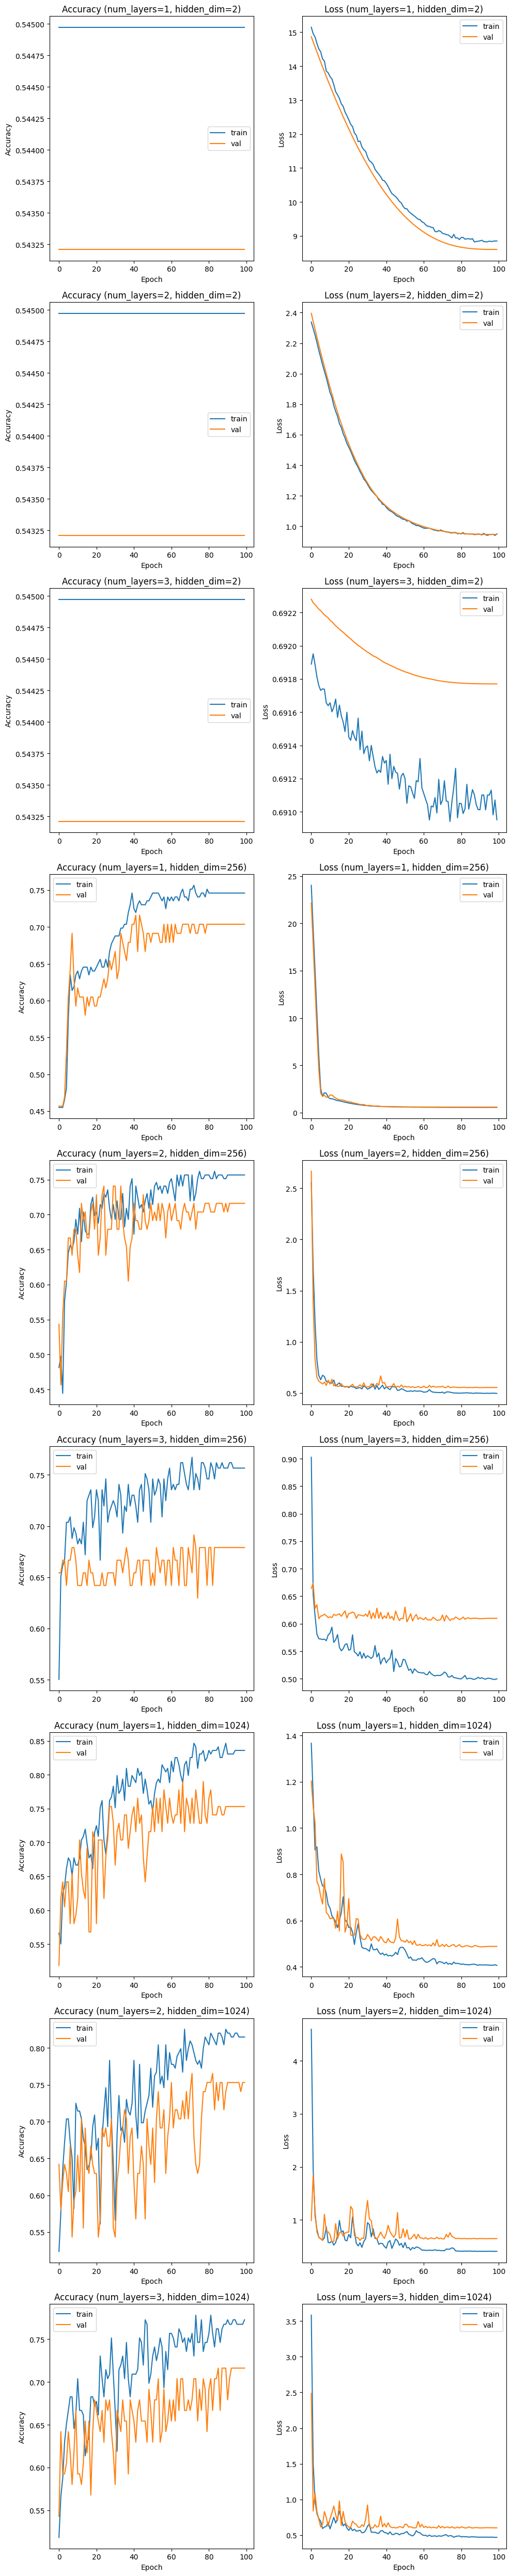

In [9]:
# prompt: I want to plot the metrics comparison of training and validation. So you need to enumerate the results, and plot training acc/loss and validation acc/loss in  subplots (N by 2, where N is the number of results)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(results), 2, figsize=(10, 50))

for i, result in enumerate(results):
    # Plot training and validation accuracy
    axes[i, 0].plot(result['train_accuracies'], label='train')
    axes[i, 0].plot(result['val_accuracies'], label='val')
    axes[i, 0].set_title(f'Accuracy (num_layers={result["num_layers"]}, hidden_dim={result["hidden_dim"]})')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('Accuracy')
    axes[i, 0].legend()

    # Plot training and validation loss
    axes[i, 1].plot(result['train_losses'], label='train')
    axes[i, 1].plot(result['val_losses'], label='val')
    axes[i, 1].set_title(f'Loss (num_layers={result["num_layers"]}, hidden_dim={result["hidden_dim"]})')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('Loss')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()
